In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import random

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [7]:
out_folder = '211113_visualize_mouse_models'
in_folder = '190406_predict_fold_change_mouse'

In [8]:
save_images = True
save_late_images = False

In [9]:
from narrative import nar181026_heat_confidence_genes

In [10]:
ref_genes = standardizer.reference_genes(10090, 'orp')  # only consider supported protein coding-genes

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [11]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
pfus=[0]

In [12]:
all_de = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'both') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]
all_de['significant'] = all_de['padj'] < 0.05

In [13]:
sign = all_de[['condition', 'significant']].groupby('condition').agg(sum)

In [14]:
from itertools import product

In [15]:
agg = []


agg_stats = []

for condition, iteration in product(all_de['condition'].unique(), range(10)):

    p = export.get_material_path(
        '{}/values_{}_{}.csv'.format(in_folder, condition, iteration))
    

    if os.path.exists(p):
        
        brought_in = pd.read_csv(p)
        brought_in.loc[:, 'condition'] = condition
    
    agg.append(brought_in)
        
        
        
    
    agg_stats.append(
    
        {
        'rho': spearmanr(brought_in['predicted'], brought_in['observed'])[0],
        'rho_pval': spearmanr(brought_in['predicted'], brought_in['observed'])[1],
        'condition': condition,
        'iteration': iteration
    })


        

In [16]:
spearmanr(brought_in['predicted'], brought_in['observed'])

SpearmanrResult(correlation=0.21589004466097025, pvalue=6.383378525440594e-14)

In [17]:
h = pd.DataFrame(agg_stats).pivot(index='condition', columns='iteration', values='rho')
hp = pd.DataFrame(agg_stats).pivot(index='condition', columns='iteration', values='rho_pval')

In [18]:
genome_wide_stats_extremes = pd.concat(
    [
        h.min(1).to_frame('rho_min'),
        h.max(1).to_frame('rho_max'),
        hp.min(1).to_frame('rho_pval_min'),
        hp.max(1).to_frame('rho_pval_max')
        
    ],
    axis='columns'

)

In [19]:
genome_wide_stats_extremes.sort_values('rho_pval_min')

,rho_min,rho_max,rho_pval_min,rho_pval_max
condition,,,,
Kidney_0_4_9,0.435595,0.515712,5.089647e-80,4.832550e-55
LI_0_4_18,0.442318,0.510783,2.450809e-79,1.188990e-57
Kidney_0_4_24,0.427534,0.500435,1.512303e-75,1.887126e-53
Cerebellum_0_4_9,0.351981,0.458401,8.397287e-64,1.495307e-36
LI_0_4_24,0.360635,0.446379,1.044041e-58,1.811538e-37
...,...,...,...,...
Blood_0_4_9,0.021920,0.130837,6.948873e-05,5.068875e-01
Blood_0_4_12,-0.006285,0.126678,1.027431e-04,8.477897e-01
GutEP_0_4_9,-0.007753,0.108703,2.388951e-04,7.939017e-01


In [20]:
d_single = pd.concat(agg)

In [21]:
d_single = d_single.groupby(['condition', 'gene_ncbi'])[['predicted', 'observed']].mean().reset_index()

In [22]:
d_single = d_single[d_single['gene_ncbi'].isin(ref_genes)]

In [23]:
agg = []

res = pd.DataFrame(index=d_single['condition'].unique())
for condition in d_single['condition'].unique():
    u = d_single[d_single['condition']==condition]

    agg.append(
    
        {
        'rho': spearmanr(u['predicted'], u['observed'])[0],
        'rho_pval': spearmanr(u['predicted'], u['observed'])[1],
        'condition': condition,
    }

    )

In [24]:
genome_wide_stats = pd.DataFrame(agg)

In [25]:
d_single

,condition,gene_ncbi,predicted,observed
0,Adrenal_0_4_12,11287.0,2.938669,7.218219
1,Adrenal_0_4_12,11298.0,-0.093143,2.634682
2,Adrenal_0_4_12,11305.0,0.014981,-0.069880
3,Adrenal_0_4_12,11306.0,0.072680,0.282119
4,Adrenal_0_4_12,11307.0,-0.057176,0.184450
...,...,...,...,...
505862,WAT_0_4_9,102637366.0,0.007943,-2.283855
505863,WAT_0_4_9,102639598.0,-0.404540,0.296119
505864,WAT_0_4_9,102902673.0,-0.200642,-0.858161
505865,WAT_0_4_9,105886298.0,-0.024689,0.375661


In [26]:
agg = []

for condition in all_de['condition'].unique():

    p = export.get_material_path(
        '{}/predictions_{}.csv'.format(in_folder, condition))
    if os.path.exists(p):
        agg.append(pd.read_csv(p))


df = pd.concat(agg).rename(columns={'Unnamed: 0': 'condition'}).set_index('condition')
df['mean'] = df.mean(1)
df.loc[:, 'min'] = df.min(1)
df.loc[:, 'max'] = df.max(1)



d = pd.merge(sign.reset_index(), df[['mean', 'min', 'max']].reset_index())
f = d['significant'] > 0
d.loc[f, 'log_significant'] = d.loc[f, 'significant'].apply(lambda x: np.log10(x))

In [27]:
d

,condition,significant,mean,min,max,log_significant
0,Adrenal_0_4_12,464.0,0.309188,0.259096,0.350171,2.666518
1,Adrenal_0_4_18,974.0,0.237433,0.192532,0.263238,2.988559
2,Adrenal_0_4_24,647.0,0.285258,0.252957,0.328871,2.810904
3,Adrenal_0_4_9,30.0,0.174306,0.122643,0.207960,1.477121
4,BAT_0_4_12,70.0,0.189746,0.152044,0.242940,1.845098
...,...,...,...,...,...,...
63,Stomach_0_4_9,3.0,0.269998,0.214651,0.351770,0.477121
64,WAT_0_4_12,86.0,0.208119,0.180139,0.230736,1.934498
65,WAT_0_4_18,90.0,0.221752,0.187451,0.281105,1.954243
66,WAT_0_4_24,108.0,0.213124,0.168224,0.280328,2.033424


In [28]:
zeros = sum(~f)

In [29]:
h = []
for j in range(zeros):
    h.append(-1 + random.randrange(0, 10)/20)
d.loc[~f, 'log_significant'] = h

In [30]:
f = d['condition'].str.contains('_0_4_[0-9]*$')
d = d[f]

In [31]:
d = pd.merge(d, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [32]:
d = d.set_index('condition')

In [33]:
spearmanr(d['log_significant'], d['mean'])

SpearmanrResult(correlation=0.33054271126064655, pvalue=0.005904584197792573)

In [34]:
f = d['older'] == 9
d.loc[f, 'color'] = 'blue'

f = d['older'] == 12
d.loc[f, 'color'] = 'cyan'


f = d['older'] == 18
d.loc[f, 'color'] = 'orange'


f = d['older'] == 24
d.loc[f, 'color'] = 'red'

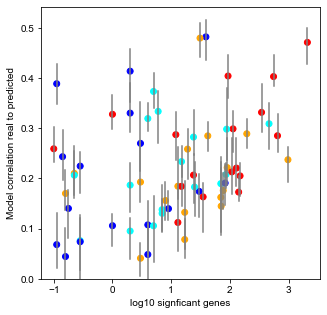

In [35]:



plt.figure(figsize=(5, 5))


for j in d.index:
    plt.plot(
        [d.loc[j, 'log_significant'], d.loc[j, 'log_significant']], 
        [d.loc[j, 'min'], d.loc[j, 'max']],
        'grey')




plt.scatter(
    d.loc[:, 'log_significant'], 
    d.loc[:, 'mean'], 

    c=d['color']
)





plt.xlabel('log10 signficant genes')
plt.ylabel('Model correlation real to predicted')
# plt.colorbar()

plt.gca().set_ylim(bottom=0)

if save_images:
    export.export_image(
    '{}/significant_genes_vs_correlation.pdf'.format(out_folder))

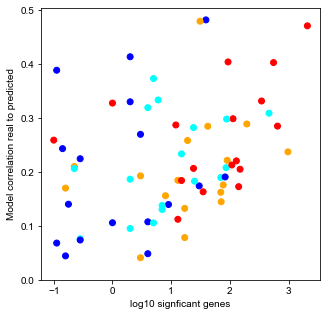

In [36]:

plt.figure(figsize=(5, 5))


# for j in d.index:
#     plt.plot(
#         [d.loc[j, 'log_significant'], d.loc[j, 'log_significant']], 
#         [d.loc[j, 'min'], d.loc[j, 'max']],
#         'grey')




plt.scatter(
    d.loc[:, 'log_significant'], 
    d.loc[:, 'mean'], 

    c=d['color']
)





plt.xlabel('log10 signficant genes')
plt.ylabel('Model correlation real to predicted')
# plt.colorbar()

plt.gca().set_ylim(bottom=0)

if save_images:
    export.export_image(
    '{}/significant_genes_vs_correlation_no_error_bar.pdf'.format(out_folder))

In [37]:
d_t = pd.merge(d.reset_index(), genome_wide_stats)

In [38]:
genome_wide_stats_extremes

,rho_min,rho_max,rho_pval_min,rho_pval_max
condition,,,,
Adrenal_0_4_12,0.259096,0.350171,1.032720e-35,9.749717e-20
Adrenal_0_4_18,0.192532,0.263238,1.504401e-20,1.588372e-11
Adrenal_0_4_24,0.252957,0.328871,1.305419e-31,6.044164e-19
Adrenal_0_4_9,0.122643,0.207960,3.931902e-13,2.142944e-05
BAT_0_4_12,0.152044,0.242940,2.542589e-16,3.768539e-07
...,...,...,...,...
Stomach_0_4_9,0.214651,0.351770,2.310329e-36,5.266049e-14
WAT_0_4_12,0.180139,0.230736,9.779005e-16,4.513988e-10
WAT_0_4_18,0.187451,0.281105,9.615165e-23,9.759799e-11


In [39]:
def helper_fun(x):
    x = -np.log10(x)
    
#     if x>50:
#         x=51

    f = x>50
    x[f] = 51


    return x

In [40]:
d_t = pd.merge(
    d_t, 
    genome_wide_stats_extremes[['rho_pval_min', 'rho_pval_max']].apply(lambda x: helper_fun(x)).reset_index()
)

In [41]:
d_t['-pval'] = -np.log10(d_t['rho_pval'].astype(float))

d_t['viz']  = d_t['-pval'].copy()
f=d_t['viz']>=50
d_t.loc[f, 'viz'] = 52

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
d_t = d_t.set_index('condition')

In [43]:
d_t.sort_values('rho_pval_max')

,significant,mean,min,max,log_significant,younger,older,color,rho,rho_pval,rho_pval_min,rho_pval_max,-pval,viz
condition,,,,,,,,,,,,,,
MuscSat_0_4_9,0.0,0.044353,-0.001643,0.100573,-0.800000,4.0,9.0,blue,0.049394,4.294214e-05,2.982053,0.018910,4.367116,4.367116
Blood_0_4_12,0.0,0.076015,-0.006285,0.126678,-0.550000,4.0,12.0,cyan,0.081719,1.767210e-10,3.988247,0.071712,9.752712,9.752712
MuscSat_0_4_18,3.0,0.041006,0.006441,0.070937,0.477121,4.0,18.0,orange,0.045606,1.406000e-04,1.702389,0.079515,3.852015,3.852015
GutEP_0_4_9,4.0,0.048424,-0.007753,0.108703,0.602060,4.0,9.0,blue,0.048690,2.939861e-05,3.621793,0.100233,4.531673,4.531673
Brain_0_4_9,0.0,0.073859,0.016794,0.121478,-0.550000,4.0,9.0,blue,0.068593,3.494126e-09,4.400249,0.243037,8.456661,8.456661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LI_0_4_24,93.0,0.404364,0.360635,0.446379,1.968483,4.0,24.0,red,0.417895,0.000000e+00,51.000000,36.741953,inf,52.000000
SI_0_4_24,554.0,0.403170,0.385018,0.445528,2.743510,4.0,24.0,red,0.400016,1.558013e-291,51.000000,42.018879,290.807429,52.000000
LI_0_4_18,31.0,0.479915,0.442318,0.510783,1.491362,4.0,18.0,orange,0.484936,0.000000e+00,51.000000,51.000000,inf,52.000000


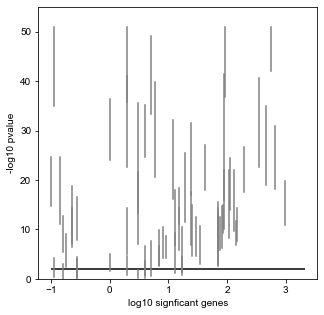

In [44]:
plt.figure(figsize=(5, 5))

for j in d.index:
    plt.plot(
        [d_t.loc[j, 'log_significant'], d_t.loc[j, 'log_significant']], 
        [d_t.loc[j, 'rho_pval_min'], d_t.loc[j, 'rho_pval_max']],
        'grey')



# plt.scatter(
#     d_t.loc[:, 'log_significant'], 
#     d_t.loc[:, 'viz'], 
#     s=40, 
#     vmin=9,
#     vmax=24,
#     c=d_t['color']


# )

plt.ylim(0, 55)

plt.hlines(y=2, xmin=-1, xmax=d_t['log_significant'].max())

plt.xlabel('log10 signficant genes')
plt.ylabel('-log10 pvalue')

if save_images:
    export.export_image(
    '{}/pvalues_of_genome_wide.pdf'.format(out_folder))



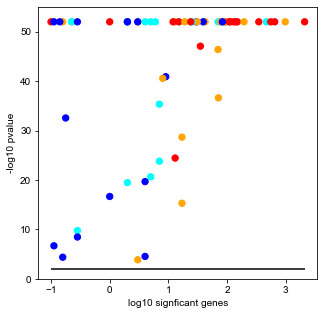

In [45]:
plt.figure(figsize=(5, 5))

# for j in d.index:
#     plt.plot(
#         [d_t.loc[j, 'log_significant'], d_t.loc[j, 'log_significant']], 
#         [d_t.loc[j, 'rho_pval_min'], d_t.loc[j, 'rho_pval_max']],
#         'grey')



plt.scatter(
    d_t.loc[:, 'log_significant'], 
    d_t.loc[:, 'viz'], 
    s=40, 
    vmin=9,
    vmax=24,
    c=d_t['color']


)

plt.ylim(0, 55)

plt.hlines(y=2, xmin=-1, xmax=d_t['log_significant'].max())

plt.xlabel('log10 signficant genes')
plt.ylabel('-log10 pvalue')

if save_images:
    export.export_image(
    '{}/pvalues_of_genome_wide_without_error_bars.pdf'.format(out_folder))


